In [1]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [2]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/bg-2-'

# Global stochasticity distribution

In [3]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909 # with _rf, the size of broken file is 266K instead of 0! 
    
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT = CUT_dedx

    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    print(np.sum(weight_corsika))
    

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4    
    CUT = CUT_dedx

    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    print(np.sum(weight_numu_astro))


516104.9538273193
12.252929558898245


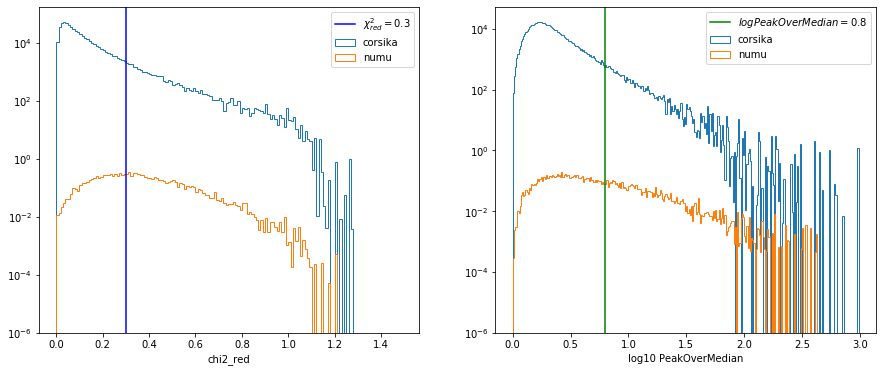

In [4]:
chi2_red_cut = 0.3
pom_cut = 0.8

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(chi2_red_numu,bins=np.arange(0,1.5,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.legend()
plt.xlabel('chi2_red')

plt.subplot(122)
plt.hist(np.log10(PeakOverMedian_corsika),bins=np.arange(0,3.0,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_numu),bins=np.arange(0,3.0,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.axvline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.legend(loc='upper right')
plt.xlabel('log10 PeakOverMedian')

plt.savefig(fig_dir + 'stochasticity_region_defined.png',dpi=600)
plt.show()

### Use chi^2_red < 0.3, log10(PeakOverMedian) < 0.8 as anti-stochasticity cuts. Updated IT inefficiency model. Did no see much difference. 

# Small IT Ineff Region

# IceTop Inefficiency

In [5]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.7
    val[dist>2200]=0.7
    return val

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


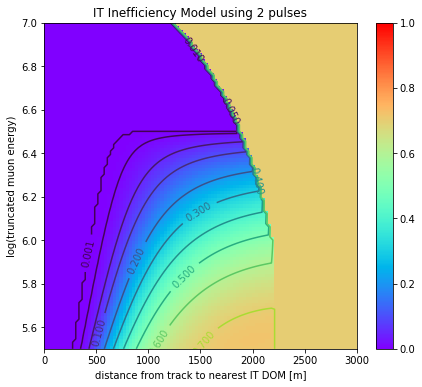

In [6]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model(xg,yg)

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.savefig(fig_dir + 'IT_ineff_model.png',dpi=300,bbox_inches='tight')
plt.show()

In [8]:
f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r')
f.root.Bundle.cols.Size

/Bundle.cols.Size (Column(865348,), float64, idx=None)

In [9]:
IT_ineff_cut = 0.01

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909 # with _rf, the size of broken file is 266K instead of 0! 
    
    ineff_corsika = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_dedx

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    b_size_corsika = f.root.Bundle.cols.Size[:][CUT]
    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    print(np.sum(weight_corsika))
    

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    ineff_numu = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_dedx

    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    print(np.sum(weight_numu_astro))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


204725.64098666035
1.8858966577262959


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


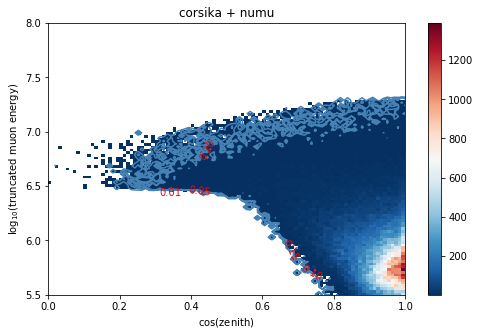

In [10]:
# ----- phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(8,5))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_corsika),np.cos(zenith_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.05,0.1,0.15,0.2],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('corsika + numu')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.pdf',bbox_inches='tight')
plt.savefig(fig_dir + 'rf_contour_global_region.png',dpi=300,bbox_inches='tight')
plt.show()

In [13]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),3  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state=42)
weights_train = X_train[:,-1] * (2)
weights_test = X_test[:,-1] * (2)
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=200,n_jobs=8,max_depth=1)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


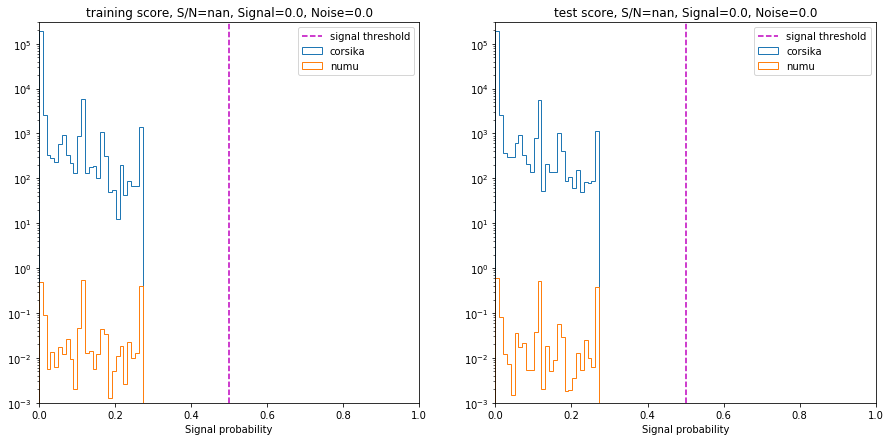

In [15]:
# training set! 
threshold = 0.5
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )
Background =  np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold])
                     
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3))+', Noise='+str(np.round(Background,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 
Background =  np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold])

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3))+', Noise='+str(np.round(Background,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

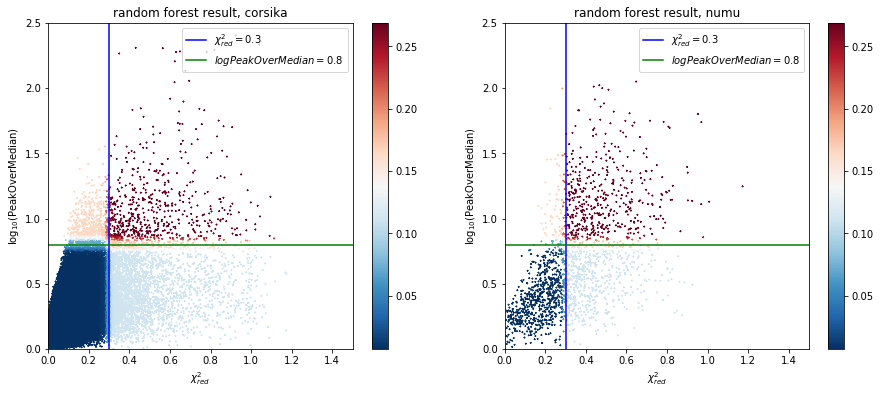

In [16]:
# ----- PeakOverMedian vs chi2_red ----- 
chi2_red_cut = 0.3
pom_cut = 0.8

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],marker='x',s=1,alpha=1,c=probability_test[y_test==0],cmap='RdBu_r') 
plt.colorbar()
plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.axhline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, corsika')

plt.subplot(122)
plt.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],marker='x',s=1,alpha=1,c=probability_test[y_test==1],cmap='RdBu_r') 
plt.colorbar()
plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.axhline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel(r'$\log_{10}$(PeakOverMedian)')
plt.legend()
plt.xlim(0,1.5)
plt.ylim(0,2.5)
plt.title('random forest result, numu')
plt.savefig(fig_dir + 'hist2d_stochasticity_region_defined.png',dpi=300,bbox_inches='tight')
plt.show()

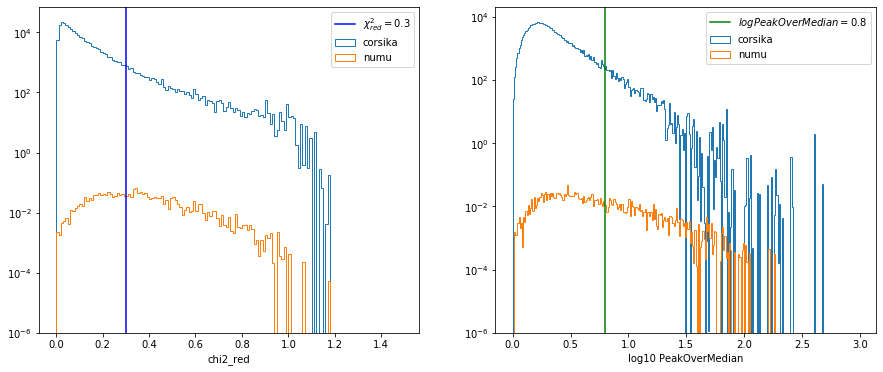

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(chi2_red_numu,bins=np.arange(0,1.5,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.legend()
plt.xlabel('chi2_red')

plt.subplot(122)
plt.hist(np.log10(PeakOverMedian_corsika),bins=np.arange(0,3.0,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_numu),bins=np.arange(0,3.0,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.axvline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.legend(loc='upper right')
plt.xlabel('log10 PeakOverMedian')

plt.savefig(fig_dir + 'hist1d_stochasticity.png',dpi=300,bbox_inches='tight')
plt.show()

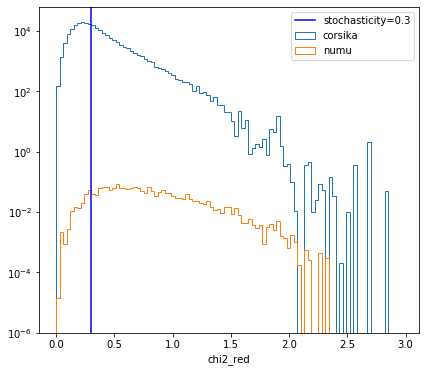

In [20]:
# trying new stochasticity metric 

plt.figure(figsize=(15,6))
plt.subplot(121)
stoch_corsika = np.sqrt(chi2_red_corsika**2+np.log10(PeakOverMedian_corsika)**2)
stoch_numu = np.sqrt(chi2_red_numu**2+np.log10(PeakOverMedian_numu)**2)
plt.hist(stoch_corsika,bins=np.arange(0,3,0.03),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(stoch_numu,bins=np.arange(0,3,0.03),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.axvline(chi2_red_cut,label=r'stochasticity='+str(chi2_red_cut),color='b')
plt.legend()
plt.xlabel('chi2_red')

plt.show()

# Energy distribution for high, low stoch region

In [21]:
chi2_red_cut = 0.3
pom_cut = 0.8

In [25]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_dedx # & CUT_untag
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

186798.0552404548


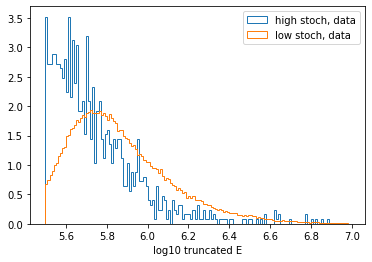

In [26]:
cut_high_stoch = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut)
cut_low_stoch = np.any([chi2_red_data_burn < chi2_red_cut,np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0)

plt.hist(np.log10(truncated_muon_e_data_burn)[cut_high_stoch],bins=np.arange(5.5,7,0.01),density=True,histtype='step',label='high stoch, data')
plt.hist(np.log10(truncated_muon_e_data_burn)[cut_low_stoch],bins=np.arange(5.5,7,0.01),density=True,histtype='step',label='low stoch, data')

# cut_high_stoch = (chi2_red_corsika > chi2_red_cut)&(np.log10(PeakOverMedian_corsika) > pom_cut)
# cut_low_stoch = np.any([chi2_red_corsika < chi2_red_cut,np.log10(PeakOverMedian_corsika) < pom_cut],axis=0)

# plt.hist(np.log10(truncated_muon_e_corsika)[cut_high_stoch],bins=np.arange(5.5,7,0.01),density=True,histtype='step',label='high stoch, corsika')
# plt.hist(np.log10(truncated_muon_e_corsika)[cut_low_stoch],bins=np.arange(5.5,7,0.01),density=True,histtype='step',label='low stoch, corsika')


plt.xlabel('log10 truncated E')
plt.legend()
plt.savefig(fig_dir + 'hist1d_truncated_for_each_stoch_region.png',dpi=300,bbox_inches='tight')

plt.show()

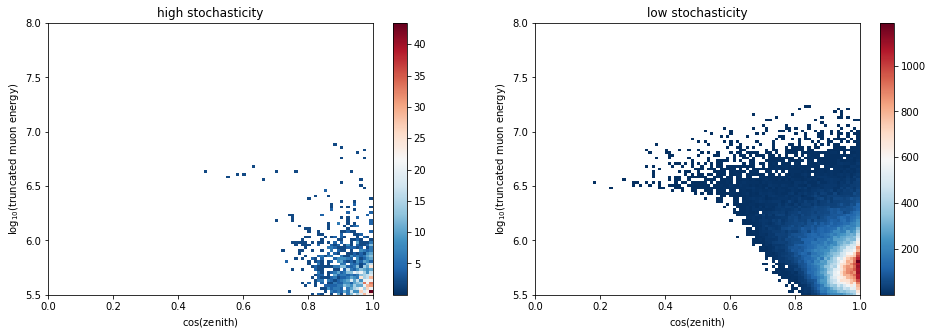

In [27]:
# ----- phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(16,5))
plt.subplot(121)
h_,yy_,xx_,img_=plt.hist2d(np.cos(zenith_data_burn)[cut_high_stoch],np.log10(truncated_muon_e_data_burn)[cut_high_stoch],cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=weight_data_burn[cut_high_stoch],vmin = 0.001)
plt.colorbar()

plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('high stochasticity')

plt.subplot(122)
h_,yy_,xx_,img_=plt.hist2d(np.cos(zenith_data_burn)[cut_low_stoch],np.log10(truncated_muon_e_data_burn)[cut_low_stoch],cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=weight_data_burn[cut_low_stoch],vmin = 0.001)
plt.colorbar()

plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('low stochasticity')

plt.savefig(fig_dir + 'hist2d_phase_spcae_each_stoch_region.png',dpi=300,bbox_inches='tight')
plt.show()

### expect low stochasticity events have higher veto probability.

# Burn Sample Background Estimation

In [41]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_dedx # & CUT_untag
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

186798.0552404548


In [42]:
# error propagation 

def err_ratio(x,y,x_err,y_err): # a/b
    return x/y*np.sqrt(  (x_err/x)**2 + (y_err/y)**2  )
def err_sum(x_err,y_err): # a+b
    return np.sqrt(x_err**2 + y_err**2)
def err_2_divide_1(x,y,t,x_err,y_err,t_err): # (a+b)/c
    return 1/t*np.sqrt(x_err**2+y_err**2+((x+y)/t)**2*t_err**2)
def err_2_divide_2(x,y,a,b,x_err,y_err,a_err,b_err): # (a+b)/(c+d)
    return np.sqrt((1/(a+b))**2*(x_err**2+y_err**2) + ((x+y)/(a+b)**2)**2*(a_err**2+b_err**2))
def err_4_divide_1(x,y,z,w,t,x_err,y_err,z_err,w_err,t_err): # (a+b+c+d)/t
    return np.sqrt(1/t**2*(x_err**2+y_err**2+z_err**2+w_err**2) + (x+y+z+w)**2/t**4*t_err**2 )
def err_prod2_divide_prod2(a,b,c,d,a_err,b_err,c_err,d_err): # (a*b)/(c*d)
    return 1/(c*d)*np.sqrt(  b**2*a_err**2+a**2*b_err**2+(a*b)**2*((c_err/c)**2+(d_err/d)**2 )   )
def err_prod2_divide_1(a,b,c,a_err,b_err,c_err):
    return a*b/c*np.sqrt( (a_err/a)**2+(b_err/b)**2+(c_err/c)**2 )
def err_prod_2(x,y,x_err,y_err): # a*b
    return x*y*np.sqrt((x_err/x)**2+(y_err/y)**2)

In [45]:
chi2_red_cut = 0.3
pom_cut = 0.8

CUT_stoch_sig_IT_sig = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & passed_2_data_burn
CUT_stoch_sig_IT_bg = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & vetoed_2_data_burn
CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & passed_2_data_burn
CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & vetoed_2_data_burn

d11 = np.sum(weight_data_burn[CUT_stoch_sig_IT_bg])
d12 = np.sum(weight_data_burn[CUT_stoch_sig_IT_sig])
d21 = np.sum(weight_data_burn[CUT_stoch_bg_IT_bg])
d22 = np.sum(weight_data_burn[CUT_stoch_bg_IT_sig])
total = np.sum(weight_data_burn) # now, sum of 4 panels is NOT total events in phase space. 

d11_len, d12_len, d21_len, d22_len = len(weight_data_burn[CUT_stoch_bg_IT_bg]),len(weight_data_burn[CUT_stoch_sig_IT_sig]),len(weight_data_burn[CUT_stoch_bg_IT_bg]),len(weight_data_burn[CUT_stoch_bg_IT_sig])

d11_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_sig_IT_bg]**2))
d12_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_sig_IT_sig]**2))
d21_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_bg_IT_bg]**2))
d22_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_bg_IT_sig]**2))
total_err = np.sqrt(np.sum(weight_data_burn**2))

df = pd.DataFrame({r"$\bf{Burn\_Sample}$": [r"$\bf{High\_Stoch}$", r"$\bf{Low\_Stoch}$", r"$\bf{All\_Stoch}$", r"$\bf{High}$ / $\bf{Low}$"],
                        r"$\bf{IT\_Vetoed}$": [r'%.4f$\pm$%.4f'%(d11/total, err_ratio(d11,total,d11_err,total_err)),
                                      r'%.4f$\pm$%.4f'%(d21/total, err_ratio(d21,total,d21_err,total_err)),
                                      r'%.4f$\pm$%.4f'%((d11+d21)/total, err_2_divide_1(d11,d21,total,d11_err,d21_err,total_err)),
                                      r'%.4f$\pm$%.4f'%(d11/d21, err_ratio(d11,d21,d11_err,d21_err)),
                                     ],
                        
                        r"$\bf{IT\_Passed}$": [r'%.4f$\pm$%.4f'%(d12/total, err_ratio(d12,total,d12_err,total_err)),
                                      r'%.4f$\pm$%.4f'%(d22/total, err_ratio(d22,total,d22_err,total_err)),
                                      r'%.4f$\pm$%.4f'%((d12+d22)/total, err_2_divide_1(d12,d22,total,d12_err,d22_err,total_err)),
                                      r'%.4f$\pm$%.4f'%(d12/d22, err_ratio(d12,d22,d12_err,d22_err)),
                                     ],
                        
                        r"$\bf{All\_IT\_Tag}$":       [r'%.4f$\pm$%.4f'%((d11+d12)/total, err_2_divide_1(d11,d12,total,d11_err,d12_err,total_err)), 
                                      r'%.4f$\pm$%.4f'%((d21+d22)/total, err_2_divide_1(d21,d22,total,d21_err,d22_err,total_err)),
                                      r'%.4f$\pm$%.4f'%((d11+d12+d21+d22)/total,err_4_divide_1(d11,d12,d21,d22,total,d11_err,d12_err,d21_err,d22_err,total_err)),
                                      r'%.4f$\pm$%.4f'%((d11+d12)/(d21+d22), err_2_divide_2(d11,d12,d21,d22,d11_err,d12_err,d21_err,d22_err)),
                                     ],
                        
                        r"$\bf{Passed}$ / $\bf{Vetoed}$": [r'%.4f$\pm$%.4f'%(d12/d11, err_ratio(d12,d11,d12_err,d11_err)),
                                          r'%.4f$\pm$%.4f'%(d22/d21, err_ratio(d22,d21,d22_err,d21_err)),
                                          r'%.4f$\pm$%.4f'%((d12+d22)/(d11+d21), err_2_divide_2(d12,d22,d11,d21,d12_err,d22_err,d11_err,d21_err)),   
                                          'N/A'
                                         ]
                    })

# info required for later calculation 
veto_reduction, veto_reduction_err = d22/d21, err_ratio(d22,d21,d22_err,d21_err)

df_events = pd.DataFrame({"N events": ["High Stoch", "Low Stoch"],
                   "IT vetoed": [d11, d21],
                   "IT passed": [d12, d22]})
print(df_events)
df

     N events      IT vetoed   IT passed
0  High Stoch    2700.510560   97.110938
1   Low Stoch  183293.796702  706.637040


,$\bf{Burn\_Sample}$,$\bf{IT\_Vetoed}$,$\bf{IT\_Passed}$,$\bf{All\_IT\_Tag}$,$\bf{Passed}$ / $\bf{Vetoed}$
0,$\bf{High\_Stoch}$,0.0145$\pm$0.0004,0.0005$\pm$0.0001,0.0150$\pm$0.0004,0.0360$\pm$0.0053
1,$\bf{Low\_Stoch}$,0.9812$\pm$0.0046,0.0038$\pm$0.0002,0.9850$\pm$0.0047,0.0039$\pm$0.0002
2,$\bf{All\_Stoch}$,0.9957$\pm$0.0047,0.0043$\pm$0.0002,1.0000$\pm$0.0047,0.0043$\pm$0.0002
3,$\bf{High}$ / $\bf{Low}$,0.0147$\pm$0.0004,0.1374$\pm$0.0214,0.0152$\pm$0.0004,N/A


In [32]:
# calculating bg using pass/veto info (equivalent (proved) by using stoch reduction ratio)
# OR:  calculating bg using direct ABCD method 
# print(d11*d22/d21)
# print(err_prod2_divide_1(d22,d11,d21,d22_err,d11_err,d21_err))

# statistical err only: 
print('total events in signal region: %.4f +/- %.4f'%(d12,d12_err))
print(r'total background in signal region: %.4f +/- %.4f'%(d11*veto_reduction, err_prod_2(d11,veto_reduction,d11_err,veto_reduction_err)))

total events in signal region: 97.1109 +/- 14.1651
total background in signal region: 10.4110 +/- 0.6333


### Number of background is underestimated! 

In [33]:
# signal and S/B depending on stoch cut 

chi2_bins = np.arange(0.1,1,0.02)
pom_bins = np.arange(0.1,1.4,0.02)

sig_in_bin = []
bg_in_bin = []
sig_to_bg_in_bin = []

chi2_list = []
pom_list = []

for i in range(len(chi2_bins)):
    for j in range(len(pom_bins)):
        chi2_red_cut = chi2_bins[i]
        pom_cut = pom_bins[j]
        
        CUT_stoch_sig_IT_sig = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & passed_2_data_burn
        CUT_stoch_sig_IT_bg = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & vetoed_2_data_burn
        CUT_stoch_bg_IT_sig = (chi2_red_data_burn < chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) < pom_cut) & passed_2_data_burn
        CUT_stoch_bg_IT_bg = (chi2_red_data_burn < chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) < pom_cut) & vetoed_2_data_burn

        d11 = np.sum(weight_data_burn[CUT_stoch_sig_IT_bg])
        d12 = np.sum(weight_data_burn[CUT_stoch_sig_IT_sig])
        d21 = np.sum(weight_data_burn[CUT_stoch_bg_IT_bg])
        d22 = np.sum(weight_data_burn[CUT_stoch_bg_IT_sig])

        sig_in_bin.append(d12-d11*d22/d21)
        bg_in_bin.append(d11*d22/d21)
        sig_to_bg_in_bin.append((d12-d11*d22/d21)/(d11*d22/d21))
        chi2_list.append(chi2_bins[i])
        pom_list.append(pom_bins[j])
        

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


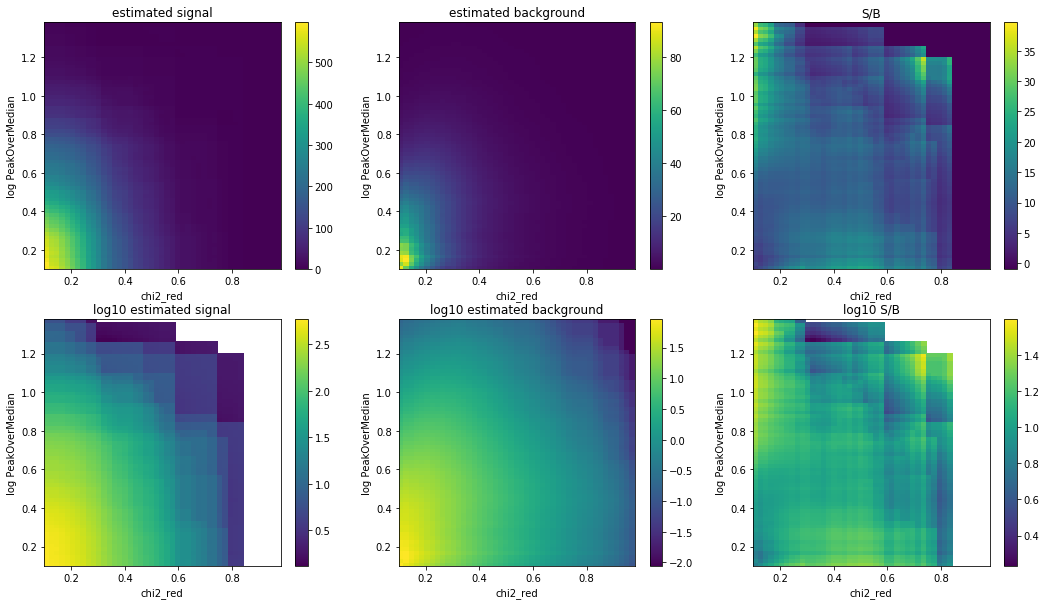

In [34]:
plt.figure(figsize=(18,10))
plt.subplot(231)
plt.hist2d(chi2_list,pom_list,weights=sig_in_bin,bins=[len(chi2_bins),len(pom_bins)])
plt.xlabel('chi2_red')
plt.ylabel('log PeakOverMedian')
plt.title('estimated signal')
plt.colorbar()

plt.subplot(232)
plt.hist2d(chi2_list,pom_list,weights=bg_in_bin,bins=[len(chi2_bins),len(pom_bins)])
plt.xlabel('chi2_red')
plt.ylabel('log PeakOverMedian')
plt.title('estimated background')
plt.colorbar()

plt.subplot(233)
plt.hist2d(chi2_list,pom_list,weights=sig_to_bg_in_bin,bins=[len(chi2_bins),len(pom_bins)])
plt.xlabel('chi2_red')
plt.ylabel('log PeakOverMedian')
plt.title('S/B')
plt.colorbar()

plt.subplot(234)
plt.hist2d(chi2_list,pom_list,weights=np.log10(sig_in_bin),bins=[len(chi2_bins),len(pom_bins)])
plt.xlabel('chi2_red')
plt.ylabel('log PeakOverMedian')
plt.title('log10 estimated signal')
plt.colorbar()

plt.subplot(235)
plt.hist2d(chi2_list,pom_list,weights=np.log10(bg_in_bin),bins=[len(chi2_bins),len(pom_bins)])
plt.xlabel('chi2_red')
plt.ylabel('log PeakOverMedian')
plt.title('log10 estimated background')
plt.colorbar()

plt.subplot(236)
plt.hist2d(chi2_list,pom_list,weights=np.log10(sig_to_bg_in_bin),bins=[len(chi2_bins),len(pom_bins)])
plt.xlabel('chi2_red')
plt.ylabel('log PeakOverMedian')
plt.title('log10 S/B')
plt.colorbar()
plt.show()

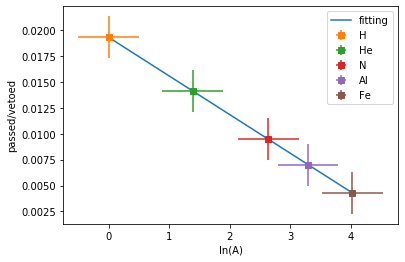

In [35]:
def pass_veto_ratio_vs_lnA(x): # obtained from bg-1-jpynb
    k, b = -0.00373303,  0.01931288
    return k*x + b

A = np.array([1,2,56])
plt.plot(np.log(A),pass_veto_ratio_vs_lnA(np.log(A)),label='fitting')
a = np.array([1,4,14,27,56])
ele = ['H','He','N','Al','Fe']
e_size = 0.5
yerr = 0.0020297421717221896
for i in range(0,len(a)):
    plt.errorbar(np.log(a[i]),pass_veto_ratio_vs_lnA(np.log(a[i])),fmt='s',xerr=[[e_size],[e_size]],
                 yerr=[[yerr],[yerr]],label=ele[i])
# plt.axhline(0.0043,label='burn sample')
plt.xlabel('ln(A)')
plt.ylabel('passed/vetoed')
plt.legend()
plt.savefig(fig_dir + 'element_uncertainty.png',dpi=300,bbox_inches='tight')
plt.show()

# Background estimation in energy-zenith bins 

In [11]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_untag = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) 
    
    CUT = CUT_ineff & CUT_dedx & CUT_untag
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

803.747978458935


In [37]:
def f(x,a,b,c):
    return a*x**2 + b*x + c # prediction in loglog space. y=x^a+b. Robust! 

total_bg_in_sig_region = 0

zen_bins = np.arange(0,1.1,0.1)
e_bins = np.arange(5.5,8.25,0.25)

for i in range(0,len(zen_bins)-1):
    for j in range(0,len(e_bins)-1):
        sampling_step = 0.001

        cut_zen = (np.cos(zenith_data_burn)>zen_bins[i]) & (np.cos(zenith_data_burn)<=zen_bins[i+1])
        cut_e = (np.log10(truncated_muon_e_data_burn)>e_bins[j]) & (np.log10(truncated_muon_e_data_burn)<=e_bins[j+1])
        h,b = np.histogram(probability_data[cut_zen&cut_e],bins=np.arange(0,0.2,sampling_step),weights=weight_data_burn[cut_zen&cut_e])    
        b = (b[:1]+b[1:])/2
        
#         h_all,b_all = np.histogram(probability_data[cut_zen&cut_e],bins=np.arange(0,0.5,sampling_step),weights=weight_data_burn[cut_zen&cut_e])    
#         b_all = (b_all[:1]+b_all[1:])/2

        # only fit nonzero pts 
        b = b[h>0]
        h = h[h>0]

        if len(h)>=3:
            popt,pcov = curve_fit(f,np.log10(b),np.log10(h),sigma=1/np.log(10)*1/h*np.sqrt(h)*np.sqrt(weight_data_burn[0]))

            # calculate bg 
            bg_region = np.arange(0.2,0.4,sampling_step)
            bg_in_bin = 10**f(np.log10(bg_region),*popt)
            total_bg = np.sum(bg_in_bin)
            
            plt.figure()
            t = np.arange(0,1,0.0001)
            plt.errorbar(b,h,yerr=np.sqrt(h)*np.sqrt(weight_data_burn[0]),fmt='_',label='data')
            plt.xlim(0,0.2)
#             plt.errorbar(np.log10(b),np.log10(h),yerr=1/np.log(10)*1/h*np.sqrt(h)*np.sqrt(weight_data_burn[0]),fmt='_',label='data')
#             plt.plot(np.log10(t), f(np.log10(t),*popt),label='fit')
            plt.axvline(np.log10(0.2),color='orange',label='score=0.6')

#             plt.plot(np.log10(b_all),np.log10(h_all),'.',label='full range')
            plt.title('zen bin '+str(i)+',E bin '+str(j)+', bg = '+str(np.round(total_bg,2)))
            plt.legend()
            plt.show()
            
        else:
            total_bg = 0
            
        total_bg_in_sig_region+=total_bg
        
print(total_bg_in_sig_region)

NameError: name 'probability_data' is not defined